# Expedia predict destination : 
The goal of this Kaggle competition is to predit the hotel of user

In [1]:
import pandas as pd
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
import xgboost as xgb
import ml_metrics as metrics
import random
%matplotlib inline 

# Functions : 

In [2]:
def string_to_datetime(s, fmt='%Y-%m-%d'):
    if s != s:
        return np.nan
    year, month, day = s.split('-')
    try:  
        d = pd.datetime(int(year), int(month), int(day))
    except ValueError:
        d = pd.datetime(2017, 1, 1)
    d = min([max([d, pd.datetime(2013, 1, 1)]), pd.datetime(2017, 1, 1)])
    return d

# Explore and vizualise data : 

In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv",nrows=5000)
destinations = pd.read_csv("destinations.csv")
submission = pd.read_csv("sample_submission.csv")
target = train.hotel_cluster

In [4]:
print "We have",train.shape[0], "train values and",train.shape[1],"variables and",test.shape[0],"test rows"

We have 5000 train values and 24 variables and 2528243 test rows


In [5]:
train.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [6]:
test.head(5)

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


We will try to extract year and month from date_time column. The test dataframe contains data from 2015 and train dataframe contains data from 2013 and 2014, so We will try to construct two dataframe silimar to main train and test data

In [7]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month
train = train[train.is_booking == True]

In [8]:
'''
unique_users = train.user_id.unique()
sel_user_ids = [unique_users[i] for i in sorted(random.sample(range(len(unique_users)), 10000)) ]
sel_train = train[train.user_id.isin(sel_user_ids)]
t1 = sel_train[((sel_train.year == 2013) | ((sel_train.year == 2014) & (sel_train.month < 8)))]
t2 = sel_train[((sel_train.year == 2014) & (sel_train.month >= 8))]
t2 = t2[t2.is_booking == True]
'''

'\nunique_users = train.user_id.unique()\nsel_user_ids = [unique_users[i] for i in sorted(random.sample(range(len(unique_users)), 10000)) ]\nsel_train = train[train.user_id.isin(sel_user_ids)]\nt1 = sel_train[((sel_train.year == 2013) | ((sel_train.year == 2014) & (sel_train.month < 8)))]\nt2 = sel_train[((sel_train.year == 2014) & (sel_train.month >= 8))]\nt2 = t2[t2.is_booking == True]\n'

## Generating features from destinations dataframe : 

We use the <b>Principal Composents Analysis PCA</b> to reduce the dimension of destinations dataframe from 149 features to only 3 features. We will also generate pther features such as day, month, year from date_time column

In [9]:
pca = PCA(n_components = 3)
dest = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])

In [10]:
dest = pd.DataFrame(dest)
dest["srch_destination_id"] = destinations["srch_destination_id"]

In [11]:
def calc_fast_features(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

train_df = calc_fast_features(train)
test_df = calc_fast_features(test)

test_df.fillna(-1, inplace=True)
train_df.fillna(-1, inplace=True)

train_df = train_df.drop('cnt', 1)
train_df = train_df.drop('is_booking', 1)

In [12]:
target = train_df.hotel_cluster

In [13]:
pd.set_option('display.max_columns', None)
train_df = train_df.drop("hotel_cluster",1)

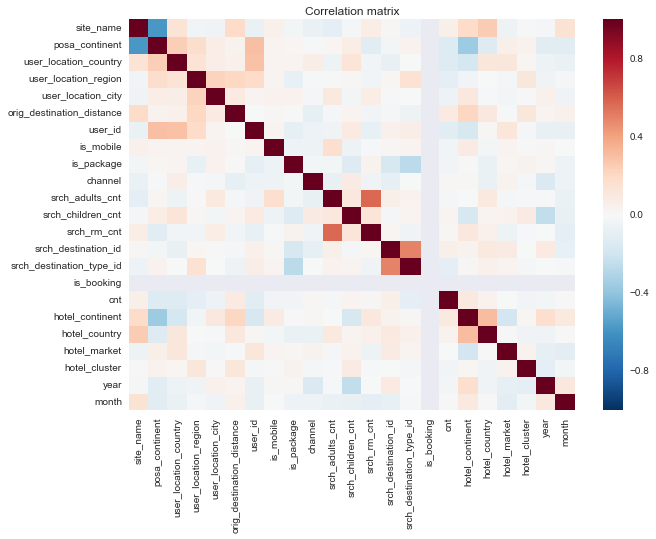

In [14]:
plt.figure(figsize=(10,7))
corr = train.corr()
sns.heatmap(corr)
plt.title("Correlation matrix")

In [15]:
train_df

,channel,ci_day,ci_dayofweek,ci_month,ci_quarter,co_day,co_dayofweek,co_month,co_quarter,day,dayofweek,hotel_continent,hotel_country,hotel_market,hour,is_mobile,is_package,minute,month,orig_destination_distance,posa_continent,quarter,site_name,srch_adults_cnt,srch_children_cnt,srch_destination_id,srch_destination_type_id,srch_rm_cnt,stay_span,user_id,user_location_city,user_location_country,user_location_region,year,0,1,2
1,9,29,4,8,3,2,1,9,3,11,0,2,50,628,8,0,1,22,8,2234.2641,3,3,2,2,0,8250,1,1,96,12,48862,66,348,2014,-0.418300,0.059863,-0.277964
20,4,18,4,4,2,20,6,4,2,27,3,2,50,191,18,0,1,1,2,-1.0000,3,1,2,2,0,8291,1,1,48,756,52078,66,318,2014,0.141730,0.140009,0.072770
27,9,6,4,9,3,14,5,9,3,15,5,0,185,185,15,0,1,38,6,-1.0000,4,2,30,2,0,1385,1,1,192,1048,56440,195,548,2013,0.366364,0.065373,-0.007332
72,9,26,4,6,2,28,6,6,2,23,6,3,151,69,18,0,0,2,11,-1.0000,4,4,30,2,0,8803,1,1,48,1048,47725,195,991,2014,0.565445,0.026197,0.035375
79,1,22,5,2,1,27,3,2,1,3,4,2,50,680,16,0,1,30,1,2454.8588,3,1,2,3,0,12009,1,2,120,1482,41898,66,462,2014,-0.581930,0.216003,0.109187
81,1,22,5,2,1,27,3,2,1,3,4,2,50,680,16,0,1,44,1,2454.8588,3,1,2,2,0,12009,1,1,120,1482,41898,66,462,2014,-0.581930,0.216003,0.109187
83,1,24,0,2,1,27,3,2,1,3,4,2,50,680,17,0,1,11,1,2454.8588,3,1,2,2,0,12009,1,1,72,1482,41898,66,462,2014,-0.581930,0.216003,0.109187
128,0,11,1,11,4,12,2,11,4,29,2,3,5,89,14,0,0,32,10,8456.8294,3,4,2,2,0,1571,3,2,24,1713,40365,66,174,2014,0.251866,0.059247,-0.012985
133,1,11,3,12,4,12,4,12,4,5,4,3,5,89,9,0,0,58,12,8393.1607,3,4,2,1,0,12861,5,1,24,1713,21855,66,174,2014,-1.084070,0.366408,-0.043009
137,0,6,5,4,2,7,6,4,2,10,3,6,204,1776,18,1,0,30,1,-1.0000,1,1,37,5,2,22494,6,3,24,2140,23649,69,923,2013,-1.328761,-0.219954,-0.196005


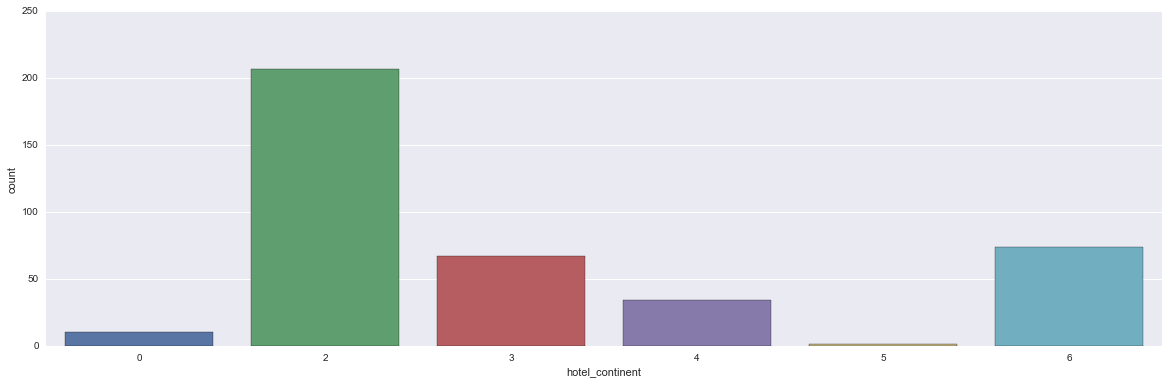

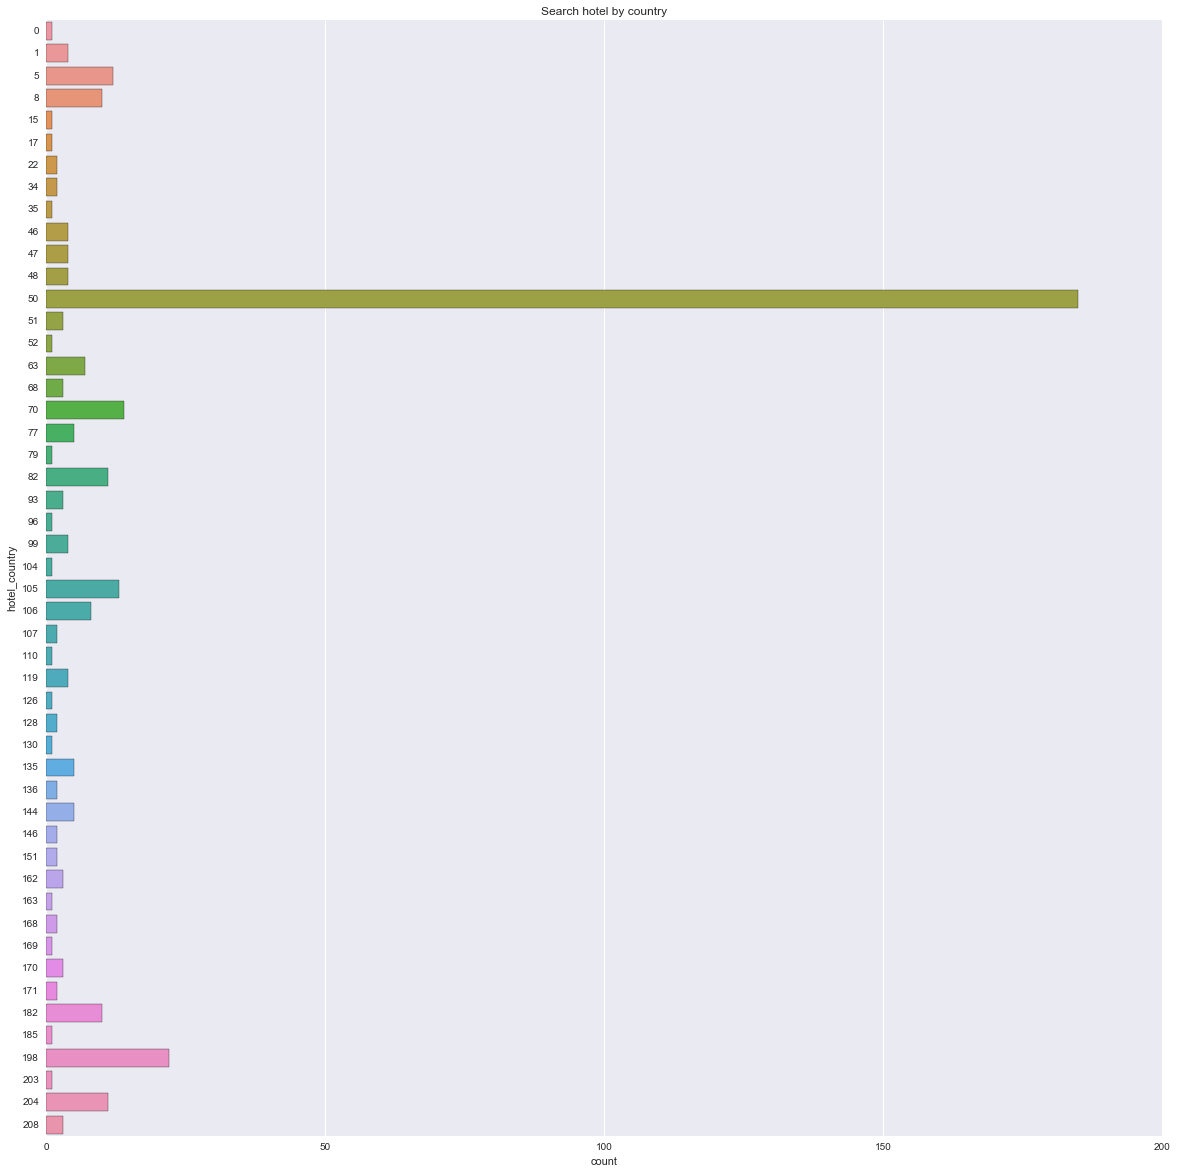

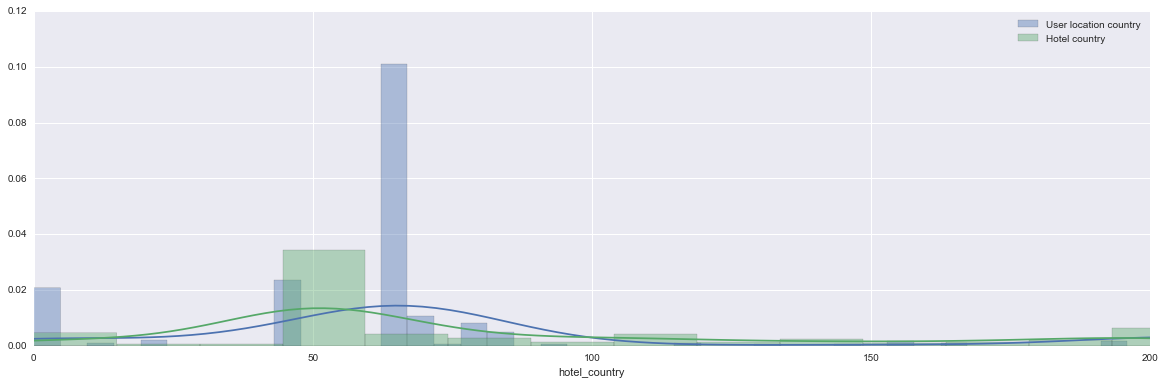

In [16]:
# Plot hotel continent histogram : 
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_continent)

# Plot hotel cluster histogram : 
#plt.figure(figsize=(20,6))
#sns.countplot(train.hotel_cluster)

# Plot hotel nights histogram : 
#plt.figure(figsize=(20,6))
#sns.countplot(train.hotel_nights)

# Plot search hotel by country 
plt.figure(figsize=(20,20))
sns.countplot(y=train.hotel_country)
plt.title("Search hotel by country")

# Kde for user location country and hotel country
plt.figure(figsize=(20,6))
sns.distplot(train.user_location_country,label="User location country")
sns.distplot(train.hotel_country,label="Hotel country")
plt.xlim([0,200])
plt.legend()

We notice that most of booking is from continent 2, and the most reccurent hotel cluster is the cluster 91 and 41

In [17]:
'''
plt.figure(figsize=(20,10))
sns.countplot(x='hotel_cluster', hue='hotel_continent', data=train)
plt.title("Hotel cluster by continent")
plt.xlim([0,50])
print "The average of booking nights is : ",np.mean(train.hotel_nights)," nights  by user"
'''

'\nplt.figure(figsize=(20,10))\nsns.countplot(x=\'hotel_cluster\', hue=\'hotel_continent\', data=train)\nplt.title("Hotel cluster by continent")\nplt.xlim([0,50])\nprint "The average of booking nights is : ",np.mean(train.hotel_nights)," nights  by user"\n'

# Variance normalization of data : 

In [18]:
normalized_train = preprocessing.normalize(train_df)
normalized_test = preprocessing.normalize(test_df)

In [19]:
'''
columns = train.columns
for col in columns : 
    if(train[col].dtype !='object'):
        print col
        print(train[col].corr(train['hotel_cluster']))
'''

"\ncolumns = train.columns\nfor col in columns : \n    if(train[col].dtype !='object'):\n        print col\n        print(train[col].corr(train['hotel_cluster']))\n"

In [20]:
print "Train colmuns :",normalized_train.shape[0], "and test columns :",normalized_test.shape[0]

Train colmuns : 393 and test columns : 2528243


# KNN (K-nearest neighbors) : 

In [25]:
clf = neighbors.KNeighborsClassifier(30, weights='distance')
clf.fit(normalized_train,target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

In [ ]:
Z = clf.predict_proba(normalized_test)
Z

In [23]:
KnnPredicted = Z.argsort(axis=1)[:,-np.arange(1,6)]
KnnPredicted

array([[90, 38, 89, 44, 68],
       [38, 90,  6, 89, 44],
       [38, 90,  6, 89, 44],
       ..., 
       [32, 54,  2, 57,  1],
       [32, 54,  2, 57,  1],
       [32, 54,  2, 57,  1]])

In [24]:
scores = cross_validation.cross_val_score(clf, normalized_train, target, cv=3)
scores

/Users/aissaelouafi/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


array([ 0.05952381,  0.06976744,  0.01041667])

## Random Forest Classifier 

In [ ]:
model = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
model.fit(normalized_train, target)
predictsRF = model.predict_proba(normalized_test)
predicted = predictsRF.argsort(axis=1)[:,-np.arange(1,6)]

In [27]:
predicted = predictsRF.argsort(axis=1)[:,-np.arange(1,6)]

In [28]:
predicted

array([[83, 32, 14,  5, 10],
       [83, 14, 32, 30, 90],
       [86, 90, 83, 14, 66],
       ..., 
       [14, 32, 10, 86, 44],
       [14, 32, 10, 86, 44],
       [32, 14, 10, 82, 86]])

In [29]:
def construct_string(a):
    """Average first and last element of a 1-D array"""
    return str(a[0])+" "+str(a[1])+" "+str(a[2])+" "+str(a[3])+" "+str(a[4])
predictedClusterString = np.apply_along_axis(construct_string, 1, KnnPredicted)

In [30]:
submissionRF = pd.read_csv("sample_submission.csv")
submissionRF['hotel_cluster'] = predictedClusterString
submissionRF.to_csv("submissionRF.csv",index=False)

In [31]:
subm = pd.read_csv("submissionRF.csv")
subm

,id,hotel_cluster
0,0,90 38 89 44 68
1,1,38 90 6 89 44
2,2,38 90 6 89 44
3,3,38 89 90 44 85
4,4,38 90 89 44 85
5,5,38 89 90 44 85
6,6,38 89 90 44 85
7,7,38 89 90 44 85
8,8,38 89 90 44 85
9,9,38 89 90 44 85
